In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import time as t
from time import perf_counter as cput
import scipy.constants as spc
import matplotlib.ticker as ticker

In [2]:
path_prefix = 'D:/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''
data_path = path_prefix + "v7/"
ext_path = "H:/EPE_file_storage/"
ext_modelpath = ext_path + "Model/"
ext_datapath = ext_path + "data_storage/"
ext_plotpath = ext_path + "plots/"

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
stmc_x = np.load(data_path + "X_img_pfn.npz")
stmc_y = np.load(data_path + "Y_img_pfn.npz")
Xraw = stmc_x.f.arr_0
Yraw = stmc_y.f.arr_0

In [5]:
t0 = t.time()
# load spcific amount of events from raw
X = Xraw[:3000000,:,:5]
Y = Yraw[:3000000]
print(X.shape)
print(Y.shape)
t1 = t.time()
print('Time to load and copy arrays: '+str(t1-t0)+' (s)')

(435967, 636, 5)
(435967,)
Time to load and copy arrays: 0.0010018348693847656 (s)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model, model_from_json
import keras.backend as Kb

In [7]:
lambda_layer = layers.Lambda(lambda X: Kb.cast(Kb.any(Kb.not_equal(X, 0.0), axis=-1), Kb.dtype(X)), output_shape=(None, None),
                                mask=None,
                                name='mask')

In [8]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [9]:
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] != 0
X[:,:,1][eta_mask] = X[:,:,1][eta_mask]/.7

phi_mask = X[:,:,2] != 0
cellPhi_std = np.std(X[:,:,2][phi_mask])
X[:,:,2][phi_mask] = X[:,:,2][phi_mask]/cellPhi_std

In [10]:
import tensorflow_probability as tfp

def point_mask_fn(X, mask_val=0.):
    return Kb.cast(Kb.any(Kb.not_equal(X, mask_val), axis=-1), Kb.dtype(X))

def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

def ParticleFlow_MDN(num_features, name="PFN_MDN_Network"):
    
    event_shape = [1]
    num_components = 4
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)


    inputs = keras.Input(shape=(None, num_features), name='input')

    dense_0 = layers.Dense(100)
    t_dist_0 = layers.TimeDistributed(dense_0, name='t_dist_0')(inputs)
    activation_0 = layers.Activation('relu', name="activation_0")(t_dist_0)
    
    dense_1 = layers.Dense(100)
    t_dist_1 = layers.TimeDistributed(dense_1, name='t_dist_1')(activation_0)
    activation_1 = layers.Activation('relu', name='activation_1')(t_dist_1)
    
    dense_2 = layers.Dense(128)
    t_dist_2 = layers.TimeDistributed(dense_2, name='t_dist_2')(activation_1)
    activation_2 = layers.Activation('relu', name='activation_2')(t_dist_2)
    
    lambda_layer = layers.Lambda(point_mask_fn, output_shape=(None, None),
                                mask=None,
                                name='mask')(inputs)

    sum_layer = layers.Dot(axes=(1,1), name='sum')([lambda_layer, activation_2])
    
    dense_3 = layers.Dense(100, name='dense_0')(sum_layer)
    activation_3 = layers.Activation('relu', name="activation_3")(dense_3)
    
    dense_4 = layers.Dense(100, name='dense_1')(activation_3)
    activation_4 = layers.Activation('relu', name="activation_4")(dense_4)
    
    dense_5 = layers.Dense(100, name='dense_2')(activation_4)
    activation_5 = layers.Activation('relu', name="activation_5")(dense_5)
    
    dense_6 = layers.Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.))(activation_5)

    
    mdn_0 = tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                          convert_to_tensor_fn=convert_to_tensor)(dense_6)
    
    return keras.Model(inputs=inputs, outputs=mdn_0, name=name)

In [12]:
# model = ParticleFlow_MDN(num_features=5)
# model.load_weights("img_pfn_mdn_regressor_4cp.h5")
model = load_model("pfn_regressor_image_).h5")


C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\layers\core.py:1043: UserWarning: energyflow.archs.efn is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [13]:
preds = np.exp(model.predict(eval_generator(X,500)).flatten())
print(preds.shape)

(435967,)


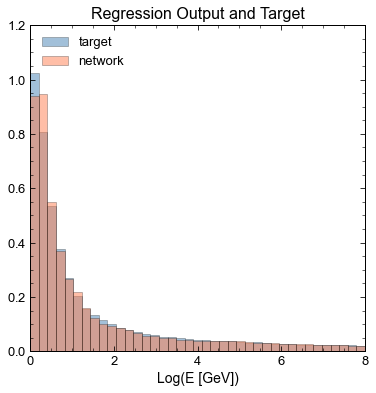

In [14]:
bins = np.linspace(0,8,40, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(Y, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [15]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu

def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))

def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution

<Figure size 799.992x599.976 with 0 Axes>

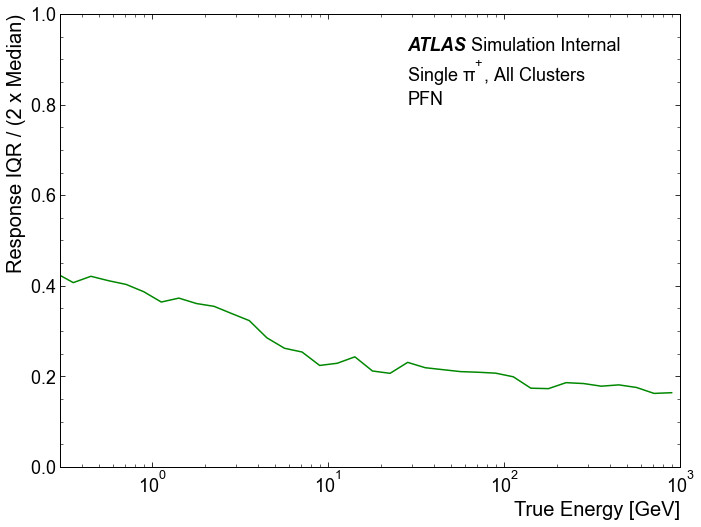

In [16]:
xcenter, iqrMDN3 = resolutionPlot(Y, preds,
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'PFN'}])

<Figure size 799.992x599.976 with 0 Axes>

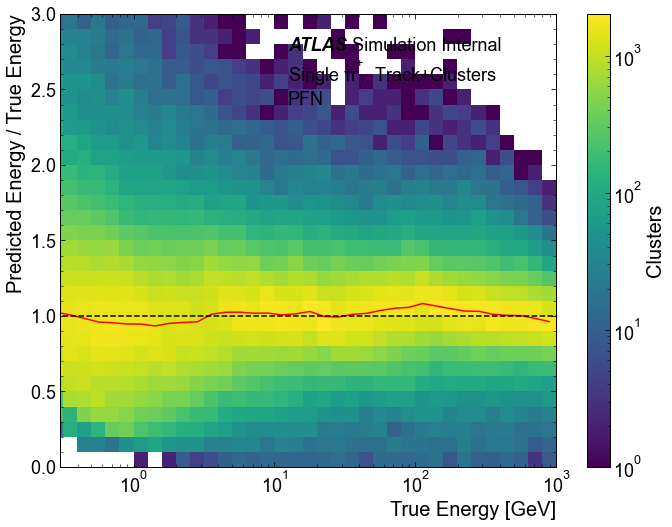

In [17]:
xcenter, medDNN = ru.responsePlot(Y, y=preds/Y,
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, Track+Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'PFN'}])

In [ ]:
# keras.utils.plot_model(model, show_shapes = True)